In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import os.path as path

import matplotlib.pyplot as plt

from rasterio import features, windows

from geographiclib.geodesic import Geodesic
from shapely.geometry import Polygon, Point

import tqdm.notebook as tqdm

from torch.utils.data import Sampler, Dataset
from typing import Iterator

/home/tranlin/anaconda3/envs/b2p/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def get_dfs():
    rwanda_df = pd.read_csv(
        "../data/ground_truth/"
        "Rwanda training data_AllSitesMinusVehicleBridges_21.11.05.csv")
    rwanda_df.dropna(inplace=True)
    print("Number of Rwanda data points: {}".format(len(rwanda_df)))

    uganda_df = pd.read_csv(
        "../data/ground_truth/Uganda_TrainingData_3districts_ADSK.csv")
    uganda_df.dropna(inplace=True)
    print("Number of Uganda data points: {}".format(len(uganda_df)))

    return rwanda_df, uganda_df

In [3]:
def get_bounds():
    
    rwanda_df, uganda_df = get_dfs()

    lat_name = "GPS (Latitude)"
    lon_name = "GPS (Longitude)"

    bounds_dict = {c: {} for c in ["rwanda", "uganda"]}

    exclude_ids = ["1023076"]
    min_lat, max_lat = float("inf"), - float("inf")
    min_lon, max_lon = float("inf"), - float("inf")
    
    for i, row in uganda_df.iterrows():
        if row["Opportunity Unique Identifier"] in exclude_ids:
            continue
        lat = row[lat_name]
        lon = row[lon_name]
        min_lat = min(min_lat, lat)
        max_lat = max(max_lat, lat)
        min_lon = min(min_lon, lon)
        max_lon = max(max_lon, lon)

    min_lat -= 300 / 3600
    max_lat += 300 / 3600
    min_lon -= 300 / 3600
    max_lon += 300 / 3600

    bounds_dict["uganda"] = {
        "left": min_lon,
        "bottom": min_lat,
        "right": max_lon,
        "top": max_lat
    }

    rwanda_fp = "../data/country_masks/used_for_pre_processing/rwanda_mask_1-3600.tiff"
    rwanda = rasterio.open(rwanda_fp)

    bounds_dict["rwanda"] = {
        "left": rwanda.bounds.left,
        "bottom": rwanda.bounds.bottom,
        "right": rwanda.bounds.right,
        "top": rwanda.bounds.top
    }
    return bounds_dict

In [4]:
def get_square_area(longitude: float, latitude: float,
                    square_length: float = 60., geod: Geodesic = None):
    """
    Args:
        lat: Latitude
        lon: Longtitude
        square_length: Measured in meters.
        geod: (Geodesic)
    """
    if geod is None:
        #Define the ellipsoid
        geod = Geodesic.WGS84
        
    diag_len = np.sqrt(2*(square_length / 2.)**2)
    lr_point = geod.Direct(latitude, longitude, 135, diag_len)
    ll_point = geod.Direct(latitude, longitude, -135, diag_len)
    ul_point = geod.Direct(latitude, longitude, -45, diag_len)
    ur_point = geod.Direct(latitude, longitude, 45, diag_len)
    return [
        # lr = lower right
        [lr_point['lon2'], lr_point['lat2']],
        # ll = lower left
        [ll_point['lon2'], ll_point['lat2']],
        # ul = upper left
        [ul_point['lon2'], ul_point['lat2']],
        # ur = upper right
        [ur_point['lon2'], ur_point['lat2']]
    ]

In [5]:
def get_rwanda_va_range(bounds):
    val_range = (
        bounds["rwanda"]["left"] + (
            bounds["rwanda"]["right"] - bounds["rwanda"]["left"]) / 11 * 5,
        bounds["rwanda"]["left"] + (
            bounds["rwanda"]["right"] - bounds["rwanda"]["left"]) / 11 * 6
    )
    return val_range

In [90]:
get_bounds()

Number of Rwanda data points: 1429
Number of Uganda data points: 251


{'rwanda': {'left': 28.854442596,
  'bottom': -2.8255556621111113,
  'right': 30.893331484888886,
  'top': -1.054444551},
 'uganda': {'left': 29.652706666666667,
  'bottom': -0.3706913333333333,
  'right': 30.683246333333333,
  'top': 0.9694093333333333}}

# Visualize western Uganda

Number of Rwanda data points: 1429
Number of Uganda data points: 251


<AxesSubplot:>

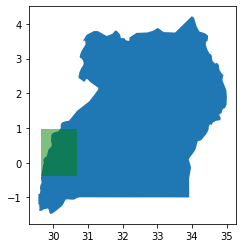

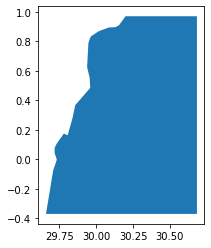

In [6]:
bounds_dict = get_bounds()

uganda_boundary = gpd.read_file(
    "../data/country_masks/used_for_pre_processing/uganda.shp")

uganda_train_bounds = Polygon([
    [bounds_dict["uganda"]["left"], bounds_dict["uganda"]["top"]],
    [bounds_dict["uganda"]["right"], bounds_dict["uganda"]["top"]],
    [bounds_dict["uganda"]["right"], bounds_dict["uganda"]["bottom"]],
    [bounds_dict["uganda"]["left"], bounds_dict["uganda"]["bottom"]],
])

ax = uganda_boundary.plot()
gpd.GeoSeries([uganda_train_bounds]).plot(ax=ax, color='green', alpha=0.5)

uganda_boundary.overlay(
    gpd.GeoDataFrame(
        [uganda_train_bounds], columns=["geometry"], crs="EPSG:4326"),
    how="intersection").plot()

# Create training data

In [102]:
thres = 50

lat_name = "GPS (Latitude)"
lon_name = "GPS (Longitude)"
crs = "EPSG:4326"
bounds = get_bounds()
va_range = get_rwanda_va_range(bounds)

rwanda_bounds = gpd.read_file(
    "../data/country_masks/used_for_pre_processing/rwanda.shp")
uganda_bounds = gpd.read_file(
    "../data/country_masks/used_for_pre_processing/uganda.shp")

# bounds for tr, va, te
uganda_te_bounds = gpd.GeoDataFrame([
    Polygon([
        [bounds["uganda"]["left"], bounds["uganda"]["top"]],
        [bounds["uganda"]["right"], bounds["uganda"]["top"]],
        [bounds["uganda"]["right"], bounds["uganda"]["bottom"]],
        [bounds["uganda"]["left"], bounds["uganda"]["bottom"]]])],
    crs=crs, columns=["geometry"]
)
uganda_te_bounds = uganda_bounds.overlay(uganda_te_bounds, how="intersection")

rwanda_tr_lower_bounds = gpd.GeoDataFrame([
    Polygon([
        [bounds["rwanda"]["left"], bounds["rwanda"]["top"]],
        [va_range[0], bounds["rwanda"]["top"]],
        [va_range[0], bounds["rwanda"]["bottom"]],
        [bounds["rwanda"]["left"], bounds["rwanda"]["bottom"]]])], 
    crs=crs, columns=["geometry"]
)
rwanda_tr_lower_bounds = rwanda_tr_lower_bounds.overlay(
    rwanda_bounds, how="intersection")

rwanda_va_bounds = gpd.GeoDataFrame([
    Polygon([
        [va_range[0], bounds["rwanda"]["top"]],
        [va_range[1], bounds["rwanda"]["top"]],
        [va_range[1], bounds["rwanda"]["bottom"]],
        [va_range[0], bounds["rwanda"]["bottom"]]
    ])], crs=crs, columns=["geometry"]
)
rwanda_va_bounds = rwanda_va_bounds.overlay(rwanda_bounds, how="intersection")

rwanda_tr_upper_bounds = gpd.GeoDataFrame([
    Polygon([
        [va_range[1], bounds["rwanda"]["top"]],
        [bounds["rwanda"]["right"], bounds["rwanda"]["top"]],
        [bounds["rwanda"]["right"], bounds["rwanda"]["bottom"]],
        [va_range[1], bounds["rwanda"]["bottom"]]
    ])], crs="EPSG:4326", columns=["geometry"]
)
rwanda_tr_upper_bounds = rwanda_tr_upper_bounds.overlay(
    rwanda_bounds, how="intersection")

# one polygon to show space of all positive points for sampling
# = tile_size - 50
# one polygon to show space of where negative points for sampling cannot be
# = tile_size - 50 + tile_size / 0.5 + tile_size / 0.5
# = tile_size - 50 + tile_size
# = 2 * tile_size - 50

for tile_size in [300, 600, 1200]:
    rwanda_df, uganda_df = get_dfs()
    
    pos_size = tile_size - thres
    non_neg_size = 2 * tile_size - 50
    # rwanda
    recid_name = "Record ID"
    
    rwanda_df[recid_name] = "rw-" + rwanda_df[recid_name]
    rwanda_df = rwanda_df.rename(columns={recid_name: "id"})
    rwanda_df.drop(["Site Name"], inplace=True, axis=1)
    # positive area
    rwanda_df["pos_polygon"] = rwanda_df.apply(
        lambda x: Polygon(
            get_square_area(x[lon_name], x[lat_name], square_length=pos_size)),
        axis=1)
    # non negative area
    rwanda_df["non_neg_polygon"] = rwanda_df.apply(
        lambda x: Polygon(
            get_square_area(
                x[lon_name], x[lat_name], square_length=non_neg_size)),
        axis=1)
    
    rwanda_df.loc[rwanda_df[lon_name] < va_range[0], "split"] = "train_lower"
    rwanda_df.loc[rwanda_df[lon_name] < va_range[0], "min_x"] = bounds[
        "rwanda"]["left"]
    rwanda_df.loc[rwanda_df[lon_name] < va_range[0], "max_x"] = va_range[0]
    
    rwanda_df.loc[(rwanda_df[lon_name] >= va_range[0]) &
                  (rwanda_df[lon_name] < va_range[1]), "split"] = "val"
    rwanda_df.loc[(rwanda_df[lon_name] >= va_range[0]) &
                  (rwanda_df[lon_name] < va_range[1]), "min_x"] = va_range[0]
    rwanda_df.loc[(rwanda_df[lon_name] >= va_range[0]) &
                  (rwanda_df[lon_name] < va_range[1]), "max_x"] = va_range[1]
    rwanda_df.loc[rwanda_df[lon_name] >= va_range[1], "split"] = "train_upper"
    rwanda_df.loc[rwanda_df[lon_name] >= va_range[1], "min_x"] = va_range[1]
    rwanda_df.loc[rwanda_df[lon_name] >= va_range[1], "max_x"] = bounds[
        "rwanda"]["right"]
    
    recid_name = "Opportunity Unique Identifier"
    uganda_df[recid_name] = "ug-" + uganda_df[recid_name]
    uganda_df = uganda_df.rename(columns={recid_name: "id"})
    uganda_df.drop(["Opportunity ID"], inplace=True, axis=1)
    uganda_df["pos_polygon"] = uganda_df.apply(
        lambda x: Polygon(get_square_area(
            x[lon_name], x[lat_name], square_length=pos_size)),
        axis=1)
    uganda_df["non_neg_polygon"] = uganda_df.apply(
        lambda x: Polygon(
            get_square_area(
                x[lon_name], x[lat_name], square_length=non_neg_size)),
        axis=1)
    uganda_df["split"] = "test"
    uganda_df["min_x"] = bounds["uganda"]["left"]
    uganda_df["max_x"] = bounds["uganda"]["right"]
    
    rwanda_tr_lower_df = gpd.GeoDataFrame(
        rwanda_df[rwanda_df.split == "train_lower"].drop(
            "pos_polygon", axis=1).rename(
                {"non_neg_polygon": "geometry"}, axis=1),
        crs="EPSG:4326"
    )
    rwanda_va_df = gpd.GeoDataFrame(
        rwanda_df[rwanda_df.split == "val"].drop(
            "pos_polygon", axis=1).rename(
                {"non_neg_polygon": "geometry"}, axis=1),
        crs="EPSG:4326"
    )
    rwanda_tr_upper_df = gpd.GeoDataFrame(
        rwanda_df[rwanda_df.split == "train_upper"].drop(
            "pos_polygon", axis=1).rename(
                {"non_neg_polygon": "geometry"}, axis=1),
        crs="EPSG:4326"
    )

    neg_uganda_te = gpd.GeoDataFrame(
        uganda_df.drop("pos_polygon", axis=1).rename(
            {"non_neg_polygon": "geometry"}, axis=1),
        crs="EPSG:4326"
    )
    rwanda_df["Country"] = "Rwanda"
    uganda_df["Country"] = "Uganda"
    df = pd.concat([rwanda_df, uganda_df]).drop(
        "non_neg_polygon", axis=1).rename({"pos_polygon": "geometry"}, axis=1)
    df["pos_neg"] = "pos"

    neg_rwanda_tr_lower = rwanda_tr_lower_bounds.overlay(
        rwanda_tr_lower_df, how="difference")
    neg_rwanda_tr_upper = rwanda_tr_upper_bounds.overlay(
        rwanda_tr_upper_df, how="difference")
    
    neg_rwanda_tr_lower = gpd.GeoDataFrame(
        neg_rwanda_tr_lower, crs="EPSG:4326", columns=["geometry"])
    neg_rwanda_tr_upper = gpd.GeoDataFrame(
        neg_rwanda_tr_upper, crs="EPSG:4326", columns=["geometry"])

    neg_rwanda_tr_lower = neg_rwanda_tr_lower.reset_index().rename(
        {"index": "id"}, axis=1)
    neg_rwanda_tr_lower["id"] = neg_rwanda_tr_lower["id"].astype(str)
    neg_rwanda_tr_lower["id"] = "rw-neg-tr-lower" + neg_rwanda_tr_lower["id"]
    neg_rwanda_tr_lower["min_x"] = bounds["rwanda"]["left"]
    neg_rwanda_tr_lower["max_x"] = va_range[0]
    neg_rwanda_tr_lower["split"] = "train-lower"
    neg_rwanda_tr_lower["Country"] = "Rwanda"
    
    neg_rwanda_tr_upper = neg_rwanda_tr_upper.reset_index().rename(
        {"index": "id"}, axis=1)
    neg_rwanda_tr_upper["id"] = neg_rwanda_tr_upper["id"].astype(str)
    neg_rwanda_tr_upper["id"] = "rw-neg-tr-upper" + neg_rwanda_tr_upper["id"]
    neg_rwanda_tr_upper["min_x"] = va_range[1] 
    neg_rwanda_tr_upper["max_x"] = bounds["rwanda"]["right"]
    neg_rwanda_tr_upper["split"] = "train-upper"
    neg_rwanda_tr_upper["Country"] = "Rwanda"

    neg_rwanda_val = rwanda_va_bounds.overlay(rwanda_va_df, how="difference")
    neg_rwanda_val = neg_rwanda_val.drop(
        "id", axis=1).reset_index().rename({"index": "id"}, axis=1)
    neg_rwanda_val["id"] = neg_rwanda_val["id"].astype(str)
    neg_rwanda_val["id"] = "rw-neg-val-" + neg_rwanda_val["id"]
    neg_rwanda_val["min_x"] = va_range[0]
    neg_rwanda_val["max_x"] = va_range[1]
    neg_rwanda_val["split"] = "val"
    neg_rwanda_val["Country"] = "Rwanda"

    neg_uganda_te = uganda_bounds.overlay(neg_uganda_te, how="difference")
    neg_uganda_te = neg_uganda_te.drop(
        "id", axis=1).reset_index().rename({"index": "id"}, axis=1)
    neg_uganda_te["id"] = neg_uganda_te["id"].astype(str)
    neg_uganda_te["id"] = "ug-neg-te-" + neg_uganda_te["id"]
    neg_uganda_te["min_x"] = bounds["uganda"]["left"]
    neg_uganda_te["max_x"] = bounds["uganda"]["right"]
    neg_uganda_te["split"] = "test"
    neg_uganda_te["Country"] = "Uganda"
    negs = pd.concat([neg_rwanda_tr_lower, neg_rwanda_tr_upper, neg_rwanda_val,
                      neg_uganda_te])
    negs["pos_neg"] = "neg"
    df_pos_neg = gpd.GeoDataFrame(
        pd.concat([df, negs]).reset_index(drop=True), crs=crs)
    df_pos_neg.to_file(
        "../data/ground_truth/v2/train_{}.geojson".format(tile_size))

Number of Rwanda data points: 1429
Number of Uganda data points: 251
Number of Rwanda data points: 1429
Number of Uganda data points: 251
Number of Rwanda data points: 1429
Number of Uganda data points: 251
Number of Rwanda data points: 1429
Number of Uganda data points: 251


# Sampler

In [11]:
# https://gis.stackexchange.com/questions/170264/python-point-in-polygon-boundary-and-vertex-check-ray-casting

In [103]:
tile_size = 1200
with open("../data/ground_truth/v2/train_{}.geojson".format(tile_size)) as f:
    train_gdf = gpd.read_file(f)

In [104]:
train_gdf

,id,GPS (Latitude),GPS (Longitude),split,min_x,max_x,Country,pos_neg,geometry
0,rw-006f100000a86EH,-2.168670,30.262610,train_upper,29.966564,30.893331,Rwanda,pos,"POLYGON ((30.26778 -2.17387, 30.25744 -2.17387..."
1,rw-006f100000dhpDZ,-2.188740,29.690270,train_lower,28.854443,29.781210,Rwanda,pos,"POLYGON ((29.69544 -2.19394, 29.68510 -2.19394..."
2,rw-006f100000ZQRps,-1.555918,30.211844,train_upper,29.966564,30.893331,Rwanda,pos,"POLYGON ((30.21701 -1.56112, 30.20668 -1.56112..."
3,rw-006f100000ZQRkP,-1.848167,30.097000,train_upper,29.966564,30.893331,Rwanda,pos,"POLYGON ((30.10217 -1.85337, 30.09183 -1.85337..."
4,rw-006f100000ZQRpz,-1.813833,30.098779,train_upper,29.966564,30.893331,Rwanda,pos,"POLYGON ((30.10395 -1.81903, 30.09361 -1.81903..."
...,...,...,...,...,...,...,...,...,...
1679,ug-1036948,0.000133,29.738337,test,29.652707,30.683246,Uganda,pos,"POLYGON ((29.74350 -0.00507, 29.73317 -0.00507..."
1680,rw-neg-tr-lower0,NaN,NaN,train-lower,28.854443,29.781210,Rwanda,neg,"MULTIPOLYGON (((29.01335 -2.52242, 29.01335 -2..."
1681,rw-neg-tr-upper0,NaN,NaN,train-upper,29.966564,30.893331,Rwanda,neg,"MULTIPOLYGON (((30.82472 -1.84667, 30.80833 -1..."
1682,rw-neg-val-0,NaN,NaN,val,29.781210,29.966564,Rwanda,neg,"MULTIPOLYGON (((29.78687 -1.65896, 29.78687 -1..."


In [78]:
t1 = list(BridgeSampler(1200, set_name="train", shuffle=False))

In [81]:
sampler = BridgeSampler(1200, set_name="train", shuffle=False)

In [110]:
import numpy as np
import pandas as pd
import rasterio

from rasterio import windows

from geographiclib.geodesic import Geodesic

from torch.utils.data import Dataset, Sampler


TRAIN_METADATA = {
    "Rwanda": {
        "population": {
            "fp": ("../data/population/"
                   "Rwanda_population_data_2020_UNadj_constrained.tif"),
            "raster_channels": [1]
        },
        "osm_imgs": {
            "fp": "../data/osm/imgs/rwanda_osm_nolab_1-50000_4326.tiff",
            "raster_channels": [1, 2, 3]
        },
        "elevation": {
            "fp": "../data/slope_elevation/elevation_rwanda.tif",
            "raster_channels": [2]
        },
        "slope": {
            "fp": "../data/slope_elevation/slope_rwanda.tif",
            "raster_channels": [2]
        }
    },
    "Uganda": {
        "population": {
            "fp": ("../data/population/"
                   "Uganda_population_data_2020_UNadj_constrained.tif"),
            "raster_channels": [1]
        },
        "osm_imgs": {
            "fp": "../data/osm/imgs/uganda_train_osm_nolab_1-50000_4326.tiff",
            "raster_channels": [1, 2, 3]
        },
        "elevation": {
            "fp": "../data/slope_elevation/elevation_uganda.tif",
            "raster_channels": [2]
        },
        "slope": {
            "fp": "../data/slope_elevation/slope_uganda.tif",
            "raster_channels": [2]
        }
    },
}

OUTPUT_SIZE = {300: (12, 12), 600: (24, 24), 1200: (48, 48)}
DATA_ORDER = ["population", "osm_imgs", "elevation", "slope"]

TRAINING_DATA = {
    300: "../data/ground_truth/v2/training_data_300.csv",
    600: "../data/ground_truth/v2/training_data_600.csv",
    1200: "../data/ground_truth/v2/training_data_1200.csv"
}


def get_square_area(longitude: float, latitude: float,
                    square_length: float = 60., geod: Geodesic = None):
    """
    Args:
        lat: Latitude
        lon: Longtitude
        square_length: Measured in meters.
        geod: (Geodesic)
    """
    if geod is None:
        # Define the ellipsoid
        geod = Geodesic.WGS84

    diag_len = np.sqrt(2 * (square_length / 2.)**2)
    lr_point = geod.Direct(latitude, longitude, 135, diag_len)
    ll_point = geod.Direct(latitude, longitude, -135, diag_len)
    ul_point = geod.Direct(latitude, longitude, -45, diag_len)
    ur_point = geod.Direct(latitude, longitude, 45, diag_len)
    return [
        # lr = lower right
        [lr_point['lon2'], lr_point['lat2']],
        # ll = lower left
        [ll_point['lon2'], ll_point['lat2']],
        # ul = upper left
        [ul_point['lon2'], ul_point['lat2']],
        # ur = upper right
        [ur_point['lon2'], ur_point['lat2']]
    ]


class BridgeDataset(Dataset):
    def __init__(self, tile_size=300, use_rnd_pos=False, transform=False):
        assert tile_size in [300, 600, 1200], "Tile size not known"

        self.tile_size = tile_size
        with open("../data/ground_truth/v2/train_{}.geojson".format(
                tile_size)) as f:
            self.train_gdf = gpd.read_file(f)
        self.data_rasters = {}
        for country, data_modalities in TRAIN_METADATA.items():
            if country not in self.data_rasters:
                self.data_rasters[country] = {}
            for data_type, data in data_modalities.items():
                self.data_rasters[country][data_type] = rasterio.open(
                    data["fp"])

        self.use_rnd_pos = use_rnd_pos
        self.transform = transform

    @staticmethod
    def shift_coords(lon, lat, tile_size=300):
        geod = Geodesic.WGS84
        lat_shift, lon_shift = np.clip(
            np.random.normal(
                loc=0.0, scale=(tile_size - 50) / 4, size=2
            ),
            - (tile_size - 50) / 2, (tile_size - 50) / 2).tolist()
        if lat_shift < 0:
            lat_shift_degree = 180
        else:
            lat_shift_degree = 0
        if lon_shift < 0:
            lon_shift_degree = 90
        else:
            lon_shift_degree = -90
        lat_shifted = geod.Direct(lat, lon, lat_shift_degree, lat_shift)
        new_lat, new_lon = lat_shifted["lat2"], lat_shifted["lon2"]
        lon_shifted = geod.Direct(new_lat, new_lon, lon_shift_degree, lat_shift)
        new_lat, new_lon = lon_shifted["lat2"], lon_shifted["lon2"]
        return new_lon, new_lat

    @staticmethod
    def sample_points_in_polygon(polygon, num_samples=1):
        points = []
        min_x, min_y, max_x, max_y = polygon.bounds
        while len(points) < number:
            x, y = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
            point = Point(x, y)
            if polygon.contains(point):
                points.append((x, y))
        return points

    def __getitem__(self, idx):
        # get dataset entry
        entry = self.train_gdf.iloc[idx]
        country = entry.Country
        # positives
        if entry.pos_neg == "pos":
            label = 1
            lon, lat = entry["GPS (Longitude)"], entry["GPS (Latitude)"]
            if self.use_rnd_pos:
                valid_point = False
                max_num_tries, num_tries = 5, 0
                while num_tries < 0 or valid_point is False:
                    num_tries += 1
                    lon, lat = self.shift_coords(lon, lat)
                    area_coords = get_square_area(
                        lon, lat, square_length=self.tile_size)
                    left = min([ac[0] for ac in area_coords])
                    right = max([ac[0] for ac in area_coords])
                    if (entry.min_x < left < entry.max_x and 
                            entry.min_x < right < entry.max_x):
                        valid_point = True
            if valid_point is False:
                lon, lat = entry["GPS (Longitude)"], entry["GPS (Latitude)"]
        elif entry.pos_neg == "neg":
            label = 0
            valid_point = False
            max_num_tries, num_tries = 5, 0
            while num_tries < 0 or valid_point is False:
                num_tries += 1
                lon, lat = self.sample_points_in_polygon(entry.geometry)
                area_coords = get_square_area(
                    lon, lat, square_length=self.tile_size)
                left = min([ac[0] for ac in area_coords])
                right = max([ac[0] for ac in area_coords])
                if (entry.min_x < left < entry.max_x and 
                        entry.min_x < right < entry.max_x):
                    valid_point = True       
        else:
            raise NotImplementedError
        
        # coordinates of area with size tile_size
        area_coords = get_square_area(
            lon, lat, square_length=self.tile_size)
        # get left = lat, bottom = lon, right = lat, top = lon
        left = min([ac[0] for ac in area_coords])
        bottom = min([ac[1] for ac in area_coords])
        right = max([ac[0] for ac in area_coords])
        top = max([ac[1] for ac in area_coords])

        imgs = []
        for data_name in DATA_ORDER:
            raster = self.data_rasters[country][data_name]
            window = windows.from_bounds(
                left, bottom, right, top, raster.transform)
            for c in TRAIN_METADATA[country][data_name]["raster_channels"]:
                r = raster.read(
                    c, window=window, out_shape=OUTPUT_SIZE[self.tile_size])
                imgs.append(np.expand_dims(r, -1))
        # TODO transform to torch.Tensor
        # TODO return label
        return np.abs(np.concatenate(imgs, -1)), label

    def __len__(self):
        return len(self.train_gdf)


class BridgeSampler(Sampler[int]):

    def __init__(self, tile_size, num_samples=None, set_name="train",
                 shuffle=True) -> None:
        assert tile_size in [300, 600, 1200], "Tile size not known"
        assert set_name in ["train", "val", "test"], "Set name not known."
        
        with open("../data/ground_truth/v2/train_{}.geojson".format(
                tile_size)) as f:
            train_gdf = gpd.read_file(f)
        
        self.num_pos_samples = len(train_gdf[
                train_gdf.split.str.startswith(set_name) & 
                (train_gdf.pos_neg == "pos")
            ])
        if num_samples is None:
            self.num_samples = 2 *  self.num_pos_samples
        else:
            assert isinstance(num_samples, int), \
                "Expected num_samples to be int"
            self.num_samples = max(num_samples, self.num_pos_samples)
        self.shuffle = shuffle
        self.train_gdf = train_gdf
        
        pos = train_gdf[
            df_pos_neg.split.str.startswith(set_name) & (
                df_pos_neg.pos_neg == "pos")
        ].index.tolist()

        neg = train_gdf[
            df_pos_neg.split.str.startswith(set_name) & (
                df_pos_neg.pos_neg == "neg")
        ].index.tolist()
        
        num_neg = max(self.num_samples - len(pos), len(neg))
        num_neg_per_neg = num_neg // len(neg)
        new_neg = []
        
        for i in range(len(neg) - 1):
            new_neg += [neg[i]] * num_neg_per_neg
        new_neg += [neg[-1]] * (num_neg -  len(new_neg))
        neg = new_neg
        
        self.indeces = list(pos + neg)

    def __iter__(self) -> Iterator[int]:
        
        if self.shuffle:
            ind_order = np.random.choice(
                list(range(len(self.indeces))), len(self.indeces),
                replace=False)
        else:
            ind_order = range(len(self.indeces))
        indeces = [self.indeces[i] for i in ind_order]
        yield from iter(indeces)

    def __len__(self) -> int:
        return self.num_samples

In [111]:
ds = BridgeDataset(1200, use_rnd_pos=True)

num_tries 1 valid_point True
num_tries 1 valid_point True
num_tries 1 valid_point True
num_tries 1 valid_point True
num_tries 1 valid_point True
num_tries 1 valid_point True
num_tries 1 valid_point True
num_tries 1 valid_point True
num_tries 1 valid_point True
num_tries 1 valid_point True


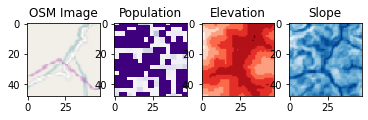

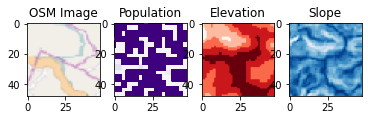

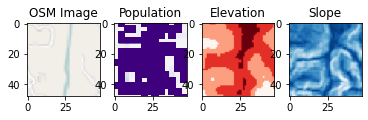

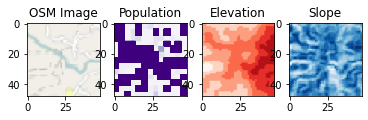

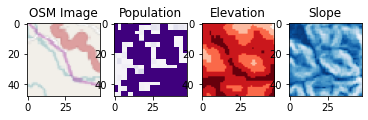

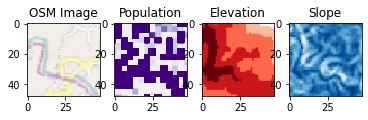

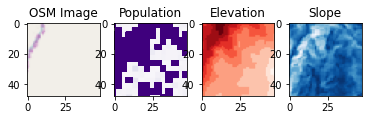

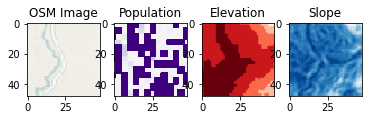

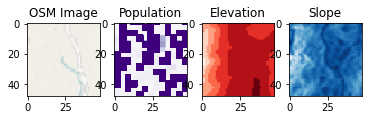

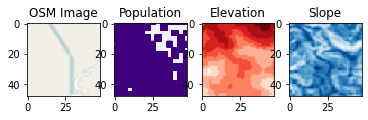

In [116]:
for _ in range(10):
    i = np.random.choice(len(ds))
    imgs, label = ds[i]
    fig, axes = plt.subplots(1, 4)
    axes[0].imshow(imgs[:, :, 1:4].astype(int))
    axes[0].set_title("OSM Image")
    axes[1].imshow(
        imgs[:, :, 0:1].astype(int), vmin=0, vmax=100, cmap="Purples")
    axes[1].set_title("Population")
    axes[2].imshow(
        imgs[:, :, 4:5].astype(int), cmap="Reds")
    axes[2].set_title("Elevation")
    axes[3].imshow(
        imgs[:, :, 5:].astype(int), cmap="Blues")
    axes[3].set_title("Slope")